# FIGURE 5 - correlation analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ishealthy = pd.read_parquet(path="../DATA/metadata/remapped/sample_health.parq")["ishealthy"]
taxonomic_table  = pd.read_parquet("../DATA/datasets/remapped/taxonomic_table.parq")
functional_table = pd.read_parquet("../DATA/datasets/remapped/functional_table.parq")

from utils import split_dataset2, triu_elements, compute_weights, add_binw_patch
from utils import compute_svd_decomposition

## Compute

**main computations needed to produce the data in the figures**

### Corr Matrices

In [2]:
def compute_correlation_matrices(dataset,ishealthy,thr_metadata=None):
    # "bal" refers to a U-subset with the same size of the H-set
    # "ubal" refers to the whole U-set
    Hds, Uds_bal, Uds_ubal = split_dataset2(dataset,ishealthy)

    # compute correlation matrices
    C_H      = Hds.T.corr().astype(np.float32)
    C_U_bal  = Uds_bal.T.corr().astype(np.float32)
    C_U_ubal = Uds_ubal.T.corr().astype(np.float32)
    C_whole  = dataset.T.corr().astype(np.float32)

    # set threshold metadata in index name
    if thr_metadata is not None:
        C_H     .index.name=f"thr={thr_metadata}"
        C_U_bal .index.name=f"thr={thr_metadata}"
        C_U_ubal.index.name=f"thr={thr_metadata}"
        C_whole .index.name=f"thr={thr_metadata}"

    return {"H":C_H, "U_bal":C_U_bal, "U_ubal":C_U_ubal,"whole":C_whole}

### Compute hstogram

In [3]:
def rolling_average(df,window=10):
    win_type = "blackmanharris"
    effective_amplitude = 0.277                     # 2*std of blackman-harris window (euristic)
    eff_window = round(window/effective_amplitude)  # rescale amplitude so that there is a corresoponding between linear binning and blackman-harris binning
    return df.rolling(window=eff_window,center=True,win_type=win_type,closed="both",min_periods=1).mean()
    
        
def compute_correlation_hists(C,dataset,ishealthy,nbins=30,window=1,resolution=10):
    
    bins = np.linspace(-1,1,nbins*resolution+1)
    Hds, Uds_bal, Uds_ubal = split_dataset2(dataset,ishealthy)

    # compute oversamples histograms
    C_hists = pd.DataFrame({"bins_center"  : 0.5*(bins[1:]+bins[:-1]),
                            "H"       : np.histogram(triu_elements(C["H"]    ) , bins=bins                                   )[0],
                            "U_bal"   : np.histogram(triu_elements(C["U_bal"]) , bins=bins                                   )[0],
                            "U_ubal"  : np.histogram(triu_elements(C["U_ubal"]), bins=bins                                   )[0],
                            "wH"      : np.histogram(triu_elements(C["H"]    ) , bins=bins, weights=compute_weights(Hds     ))[0],
                            "wU_bal"  : np.histogram(triu_elements(C["U_bal"]) , bins=bins, weights=compute_weights(Uds_bal ))[0],
                            "wU_ubal" : np.histogram(triu_elements(C["U_ubal"]), bins=bins, weights=compute_weights(Uds_ubal))[0]  }).set_index("bins_center",drop=True)

    # rolling average on oversampled histogram    
    C_hists = rolling_average(C_hists,window=window*resolution)
    C_hists.binw = (bins[1]-bins[0])*window*resolution

    return C_hists

### Compute all

In [4]:
def compute_figure_5(dataset_fun,dataset_tax,ishealthy):
    DATA = { "dataset_fun" : dataset_fun,
             "dataset_tax" : dataset_tax,
             "ishealthy"   : ishealthy,
             "C_fun"       : compute_correlation_matrices(dataset_fun,ishealthy),
             "C_tax"       : compute_correlation_matrices(dataset_tax,ishealthy)  }
    DATA["C_hists_fun"] = compute_correlation_hists(DATA["C_fun"],dataset_fun,ishealthy,nbins=30,window=1,resolution=10)
    DATA["C_hists_tax"] = compute_correlation_hists(DATA["C_tax"],dataset_tax,ishealthy,nbins=30,window=1,resolution=10)

    return DATA

DATA = compute_figure_5(functional_table,taxonomic_table,ishealthy)

## Plot
**make plots starting from the previously computed data**

### Subplots

In [5]:
def corr_vs_ma_subplot(ax,ds,C,nbins,window=1,resolution=10,marginals=False):
    logw = np.log10(compute_weights(ds))
    c    = triu_elements(C["whole"])

    # bins grid
    xbins = np.linspace(-1,1,nbins[0]*resolution+1)
    ybins = np.linspace(logw[np.isfinite(logw)].min(),logw.max(),nbins[1]*resolution+1)

    # histogram 
    h = np.histogram2d(x=c,y=logw,bins=(xbins,ybins))[0]
    if marginals:
        h[-1,:] = h.mean(axis=0)
        h[:,-1] = h.mean(axis=1)
        h[-1,-1] = np.nan

    # kernel convolution
    h = pd.DataFrame(h)
    h = rolling_average(rolling_average(h.T,window=window*resolution).T,window=window*resolution)

    # plot
    ax.pcolormesh(xbins,ybins,h.T,shading="flat",cmap="binary")
    ax.set_xlabel(r"correlation matrix values")
    ax.set_ylabel(r"log10 ma$\otimes$ma values")

    # binwidth patches
    xbinw = (xbins[1]-xbins[0])*window*resolution
    ybinw = (ybins[1]-ybins[0])*window*resolution
    add_binw_patch(ax,binw=xbinw,axis=0,label=True)
    add_binw_patch(ax,binw=ybinw,axis=1,label=False)

    #print(f"{xbinw=}")
    #print(f"{ybinw=}")

    return None

In [6]:
# fixed fun/tax, compares weighted/unweighted and H/U histograms
def correlation_hists_subplot(ax,C_hists,log=False,Hcol="blue",Ucol="darkorange"):
    
    binsc = C_hists.index
    b     = binsc[1]-binsc[0] # bins spacing

    # nomalization constant
    norm_H_w = C_hists[f"wH"     ].sum()*b
    norm_U_w = C_hists[f"wU_ubal"].sum()*b
    norm_H_u = C_hists[f"H"      ].sum()*b
    norm_U_u = C_hists[f"U_ubal" ].sum()*b

    ax.plot(C_hists.index,C_hists[ "U_ubal"]/norm_U_u,alpha=0.5,linestyle="--",label=f"U hist" ,color=Ucol)
    ax.plot(C_hists.index,C_hists[ "H"     ]/norm_H_u,alpha=0.5,linestyle="--",label=f"H hist" ,color=Hcol)
    ax.plot(C_hists.index,C_hists["wU_ubal"]/norm_U_w,alpha=1  ,linestyle="-" ,label=f"U w-hist",color=Ucol)
    ax.plot(C_hists.index,C_hists["wH"     ]/norm_H_w,alpha=1  ,linestyle="-" ,label=f"H w-hist",color=Hcol)

    if log: ax.set_yscale("log")
    
    ax.set_xlabel("correlation values")
    ax.set_ylabel("density")

    add_binw_patch(ax,binw=C_hists.binw)

    ax.legend()

    return None


In [7]:
def eigenvalues_comparison_subplot(ax,dataset,ishealthy,n=10,logy=False,Hcol="green",Ucol="red"):

    Hds,_,Uds = split_dataset2(dataset,ishealthy)

    def relative_eigenv(ds,n=n,standardize=False):
        N = dataset.shape[1]                                        # number of samples in the dataset
        SVD = compute_svd_decomposition(ds,standardize=standardize) # compute SVD basis
        eigv = SVD["S"][:n]**2/(N-1)                                # compute corr/cov matrix eigenvalues from singular values
        return eigv/eigv.max()                                      # normalize with respect to max
    
    # weight
    Hw = pd.DataFrame(Hds.sum(axis=1).values[:,None]*Hds.sum(axis=1).values[None,:],index=Hds.index,columns=Hds.index)
    Uw = pd.DataFrame(Uds.sum(axis=1).values[:,None]*Uds.sum(axis=1).values[None,:],index=Uds.index,columns=Uds.index)

    # plot the values
    ax.plot(np.arange(n),relative_eigenv(Uds,n,standardize=True ),linestyle="--",marker=".",label="U corr",color=Ucol,alpha=0.5)
    ax.plot(np.arange(n),relative_eigenv(Hds,n,standardize=True ),linestyle="--",marker=".",label="H corr",color=Hcol,alpha=0.5)
    ax.plot(np.arange(n),relative_eigenv(Uds,n,standardize=False),linestyle="-" ,marker="x",label="U cov" ,color=Ucol)
    ax.plot(np.arange(n),relative_eigenv(Hds,n,standardize=False),linestyle="-" ,marker="x",label="H cov" ,color=Hcol)


    # tweak
    ax.set_xlabel("decreasing eigenvalues")
    ax.set_ylabel(r"$\lambda/\lambda_{max}$")
    #ax.grid(True)
    ax.legend()
    
    if logy: ax.set_yscale("log")

### Plot all

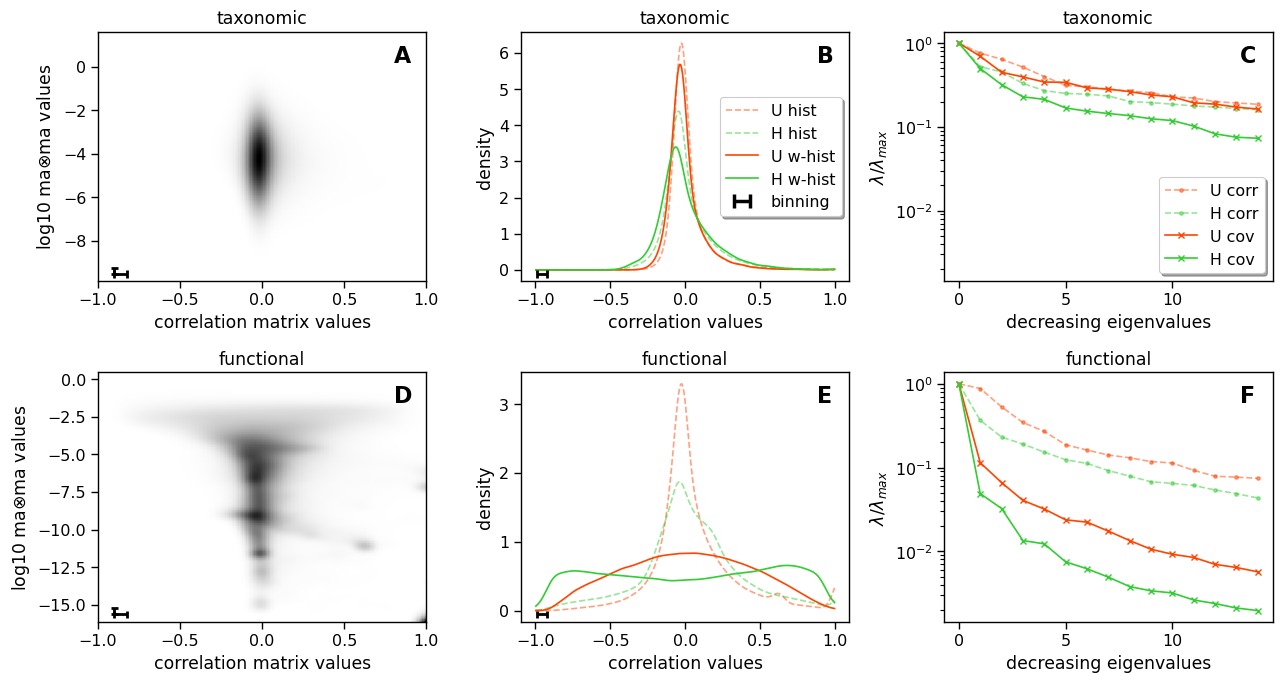

In [8]:
def plot_figure_5(dataset_fun,dataset_tax,ishealthy,C_fun,C_tax,C_hists_fun,C_hists_tax,savepath=None):
    # correlation_analisys

    import seaborn as sns
    sns.set_context('paper', font_scale=1.3)
    
    Hcol="limegreen"#"blue"
    Ucol="orangered"#"darkorange"

    fig, axs = plt.subplots(2,3,figsize=(13,7))

    # corr vs mad (col #0)
    if True:
        nbins=(25,40)
        corr_vs_ma_subplot(axs[0,0],dataset_tax,C_tax,nbins)
        corr_vs_ma_subplot(axs[1,0],dataset_fun,C_fun,nbins) 
        axs[0,0].set_title("taxonomic")
        axs[1,0].set_title("functional")

    # correlation histograms (col #1)
    if True:
        correlation_hists_subplot(axs[0,1],C_hists_tax,log=False,Hcol=Hcol,Ucol=Ucol)
        correlation_hists_subplot(axs[1,1],C_hists_fun,log=False,Hcol=Hcol,Ucol=Ucol) 
        axs[0,1].legend(loc="center right",fancybox=True, shadow=True)
        axs[1,1].legend().set_visible(False)
        axs[0,1].set_title("taxonomic")
        axs[1,1].set_title("functional")

    # eigenvalues comparison (col #2)
    if True:
        eigenvalues_comparison_subplot(axs[0,2],dataset_tax,ishealthy,n=15,logy=True,Hcol=Hcol,Ucol=Ucol)
        eigenvalues_comparison_subplot(axs[1,2],dataset_fun,ishealthy,n=15,logy=True,Hcol=Hcol,Ucol=Ucol)
        axs[0,2].sharey(axs[1,2])
        axs[0,2].legend(loc="lower right",fancybox=True, shadow=True)
        axs[1,2].legend().set_visible(False)
        axs[0,2].set_title("taxonomic")
        axs[1,2].set_title("functional")

    # tweack
    fig.tight_layout()
    #fig.subplots_adjust(wspace=0.3)

    # subplot name patches
    for ax,label in zip(axs.ravel(),('A', 'B', 'C', 'D', 'E', 'F')):
        ax.text(x=0.90, y=0.95, s=label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')

    # export images/display
    if savepath is not None: plt.savefig(fname=savepath, dpi="figure", format="pdf")
    plt.show()


# plot/save
savepath = "../RESULTS/Figure_5_correlation_analysis.pdf"
plot_figure_5(**DATA,savepath=savepath)